In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import json
import mrcfile
import umap

from cryo_sbi.inference.models import build_models
from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors
from cryo_sbi.utils.estimator_utils import sample_posterior, compute_latent_repr
from cryo_sbi.utils.image_utils import (
    LowPassFilter,
    NormalizeIndividual,
    MRCtoTensor,
    FourierDownSample,
    Mask,
)

In [53]:
class WhitenImage:
    def __init__(self, noise_psd):
        self.noise_psd = noise_psd

    def __call__(self, image):
        fft_image = torch.fft.fft2(image)
        fft_image = fft_image / torch.sqrt(self.noise_psd)
        reconstructed = torch.fft.ifft2(fft_image).real
        return reconstructed

In [54]:
transform = transforms.Compose(
    [
        MRCtoTensor(),
        FourierDownSample(256, 128),
        WhitenImage(torch.load("noise_psd.pt")),
        NormalizeIndividual(),
        Mask(128, 60),
    ]
)

In [55]:
particles = []
for i in range(1, 70):
    if i < 10:
        img_file = f"../../6wxb/particles/particles_0{i}.mrc"
    else:
        img_file = f"../../6wxb/particles/particles_{i}.mrc"
    tmp_images = transform(img_file)
    particles.append(tmp_images)
particles = torch.cat(particles, dim=0)

In [56]:
file_name = "6wxb_nma"  # File name
data_dir = "../experiments/6wxb/"
train_config = json.load(open(data_dir + "resnet18_fft_encoder.json"))
estimator = build_models.build_npe_flow_model(train_config)
estimator.load_state_dict(torch.load(data_dir + "whitening_posterior.estimator"))
estimator.cuda()
estimator.eval();

In [57]:
samples = sample_posterior(
    estimator, particles, num_samples=10000, device="cuda", batch_size=1000
)

In [58]:
latent = compute_latent_repr(estimator, particles, batch_size=100, device="cuda")

In [59]:
from sklearn.cluster import (
    DBSCAN,
    KMeans,
    OPTICS,
    AgglomerativeClustering,
    SpectralClustering,
)
from sklearn import metrics

In [60]:
particles_clustering = particles.reshape(particles.shape[0], -1).numpy()
latent_clustering = latent.numpy()

In [61]:
db_particles = KMeans(n_clusters=10, n_init="warn").fit(particles_clustering)
db_latent = KMeans(n_clusters=10, n_init="warn").fit(latent_clustering)

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [62]:
labels_particles = db_particles.predict(particles_clustering)
labels_latent = db_latent.predict(latent_clustering)

In [63]:
posterior_quantiles = np.quantile(samples.numpy(), [0.025, 1 - 0.025], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()
posterior_means = samples.mean(dim=0)

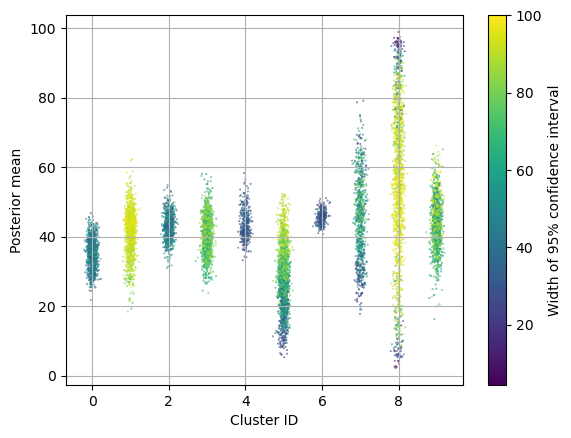

In [81]:
plt.scatter(
    labels_latent + 0.07 * np.random.randn(len(labels_latent)),
    posterior_means.numpy(),
    c=confidence_widths,
    s=0.1,
)
plt.xlabel("Cluster ID")
plt.ylabel("Posterior mean")
plt.colorbar(label="Width of 95% confidence interval")
plt.grid()

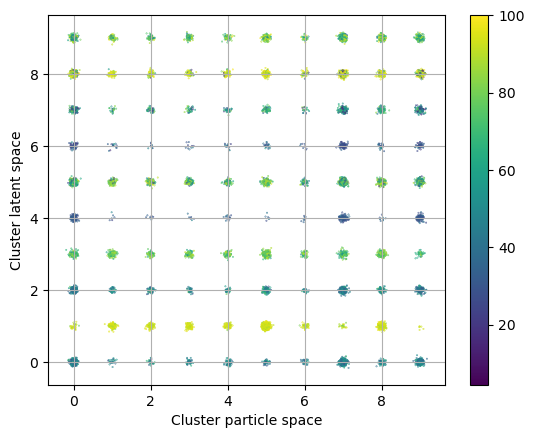

In [82]:
plt.scatter(
    labels_particles + 0.05 * np.random.randn(len(labels_particles)),
    labels_latent + 0.05 * np.random.randn(len(labels_particles)),
    c=confidence_widths,
    s=0.1,
)
plt.ylabel("Cluster latent space")
plt.xlabel("Cluster particle space")
plt.colorbar()
plt.grid()

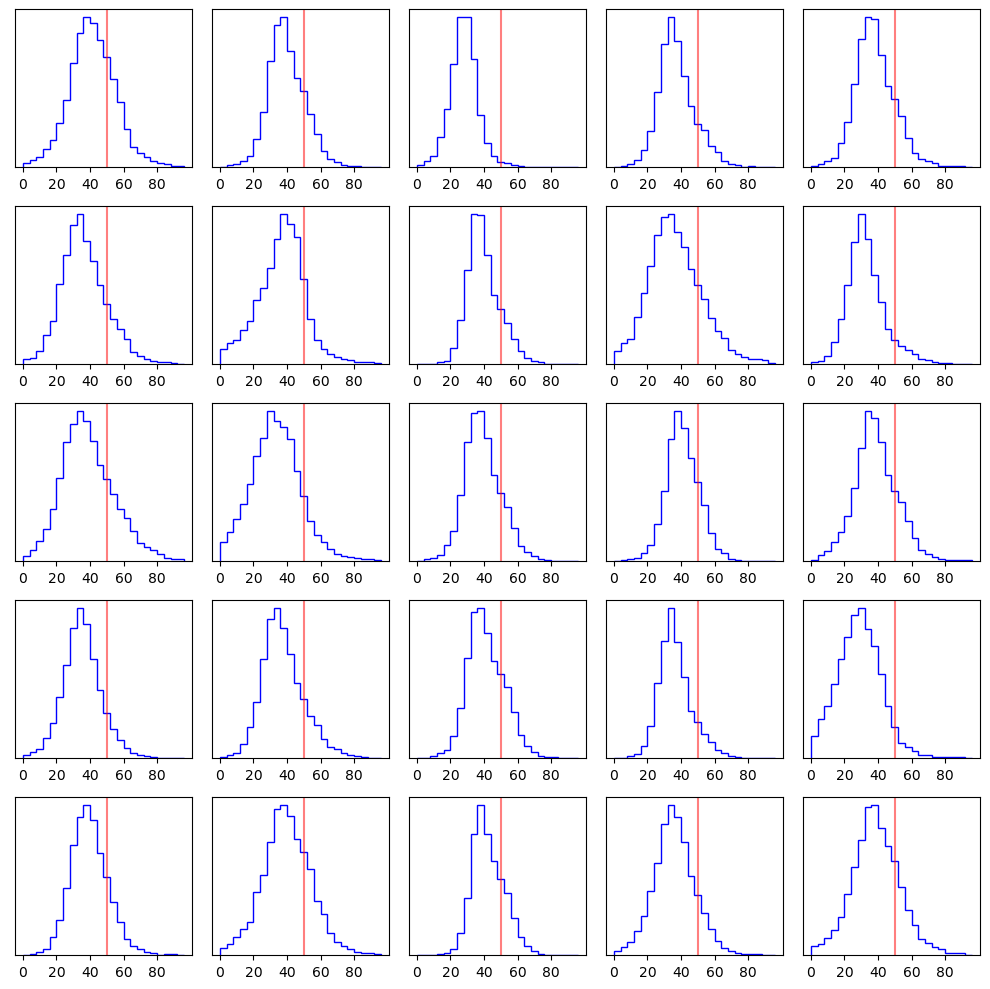

In [117]:
idx_latent = torch.from_numpy(labels_latent == 0)
idx = torch.arange(0, len(idx_latent), 1)[idx_latent]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.hist(
        samples[:, idx[i]].numpy(),
        bins=np.arange(0, 100, 4),
        density=True,
        histtype="step",
        color="blue",
    )
    ax.set_yticks([])
    ax.set_xticks(range(0, 100, 20))
    ax.axvline(50, color="red", alpha=0.5)
fig.tight_layout()

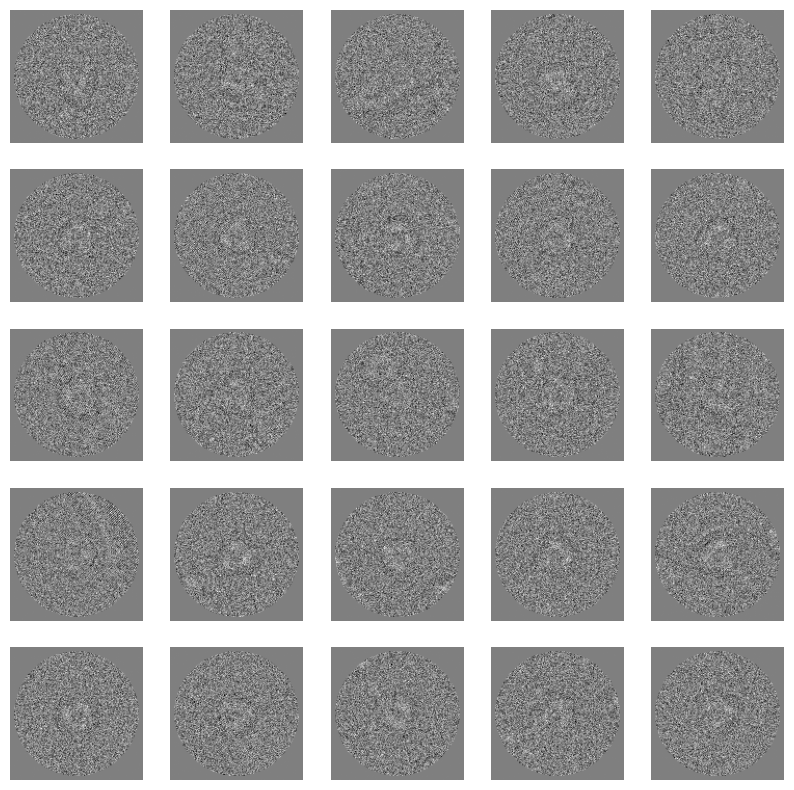

In [118]:
idx_latent = torch.from_numpy(labels_latent == 0)
idx = torch.arange(0, len(idx_latent), 1)[idx_latent]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(particles[idx[i]], cmap="binary", vmin=-4, vmax=4)
    ax.axis("off")